# COGS 118B Final Project
## Spectral Clustering Component
#### Group Members: Devon Rojas, Tayler Shaw, Christina Yu, Richard Duong, Efrain Contreras, Kastilla White
#### Github: https://github.com/devonrojas/COGS118B

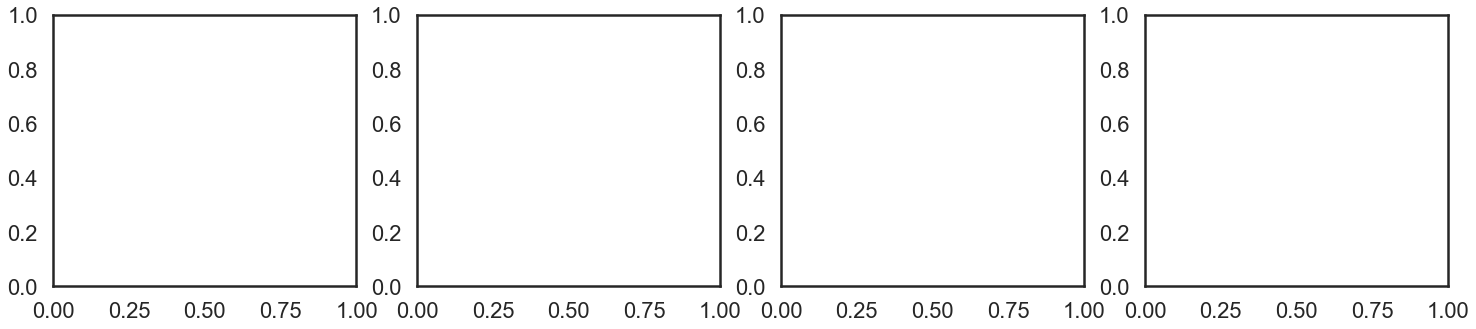

In [18]:
import numpy as np
import scipy.io as sio
from scipy.spatial.distance import euclidean, pdist, squareform
from scipy.sparse import csgraph
import matplotlib
import matplotlib.pyplot as plt
from numpy.matlib import repmat
import pandas
import seaborn as sns
from sklearn.cluster import KMeans

%matplotlib inline
sns.set_context('poster')
sns.set_style('white')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.5, 's' : 80, 'linewidths':0}

fig_nonPCA, axes_nonPCA = plt.subplots(1,4)
fig_nonPCA.set_figheight(5)
fig_nonPCA.set_figwidth(25)

In [ ]:
# [Vsort,Dsort] = eigsort(V, eigvals)
#
# Sorts a matrix eigenvectors and a array of eigenvalues in order
# of eigenvalue size, largest eigenvalue first and smallest eigenvalue
# last.
#
# Example usage:
# di, V = np.linarg.eig(L)
# Vnew, Dnew = eigsort(V, di)
#
# Tim Marks 2002

In [19]:
def eigsort(V, eigvals):

    # Sort the eigenvalues from largest to smallest. Store the sorted
    # eigenvalues in the column vector lambd.
    lohival = np.sort(eigvals)
    lohiindex = np.argsort(eigvals)
    lambd = np.flip(lohival)
    index = np.flip(lohiindex)
    Dsort = np.diag(lambd)

    # Sort eigenvectors to correspond to the ordered eigenvalues. Store sorted
    # eigenvectors as columns of the matrix vsort.
    M = np.size(lambd)
    Vsort = np.zeros((M, M))
    for i in range(M):
        Vsort[:, i] = V[:, index[i]]
    return Vsort, Dsort

## Spectral Clustering w/o PCA

In [20]:
filenames = ['winequality-red.csv', 'winequality-white.csv']
names = ["fixed acidity",
         "volatile acidity",
         "citric acid",
         "residual sugar",
         "chlorides",
         "free sulfur dioxide",
         "total sulfur dioxide",
         "density",
         "pH",
         "sulphates",
         "alcohol",
         "quality"]

d = []
for filename in filenames:
    df = pandas.read_csv(filename, names=names, sep=";")
    d.append(df)

data = pandas.concat(d, ignore_index=True)
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [21]:
# pdist(data, similarity_func)
#
# Computes the affinity value between two vectors using the euclidean
# norm squared divided by the variance of the data

# Example usage:
# dists = pdist(data, similarity_func)
def similarity_func(u, v):
    sigsq = 1600
    x = u - v
    d = - (x.dot(x.T)) / (2*sigsq)
    return np.exp(d)

In [22]:
## Step 1/2: Compute affinity/similarity matrix, set diagonal entries to 0
## Set std to 40 bc 0.9 was wayyyy too small
dists = pdist(data, similarity_func)
W = pandas.DataFrame(squareform(dists), columns=list(range(0,data.shape[0])))

In [23]:
ax = axes_nonPCA[0]
ax.set_title("Affinity Matrix")
im = ax.imshow(W, extent=[0,data.shape[0],0,data.shape[0]])
fig_nonPCA.colorbar(im, ax=ax)

In [24]:
## Step 3: Computer normalized graph Laplacian
D = np.diag(np.sum(W.T, axis=0))
L = np.linalg.inv(np.sqrt(D)).dot(W).dot(np.linalg.inv(np.sqrt(D)))
vmax = np.amax(np.ndarray.max(L, axis=0))
vmin = np.amin(np.ndarray.min(L, axis=0))

ax = axes_nonPCA[1]
ax.set_title("Normalized Graph Laplacian")
im = ax.imshow(L, extent=[0, data.shape[0], 0, data.shape[0]])
im.set_clim(vmin, vmax/250) # Dividing vmax by a large enough constant to get good color on the graph
fig_nonPCA.colorbar(im, ax=ax)

In [25]:
## Step 4: Compute top k eigenvectors
num_eigvec = 2
di, X = np.linalg.eig(L)
Xsort, Dsort = eigsort(X,di)
Xuse = Xsort[:, :num_eigvec]

ax = axes_nonPCA[2]
ax.set_title("Top k Eigenvectors")
im = ax.imshow(Xuse, extent=[0, 1, 0, 1])
fig_nonPCA.colorbar(im, ax=ax)

In [26]:
## Step 5: Compute Y by normalizing X
Xsq = np.multiply(Xuse, Xuse)
divmat = repmat(np.sqrt(np.sum(Xsq.T, axis=0)).reshape(-1,1), 1, 2)
Y = np.divide(Xuse, divmat)

ax = axes_nonPCA[3]
ax.set_title("Normalized Eigenvectors")
im = ax.imshow(Y, extent=[0, 1, 0, 1])
fig_nonPCA.colorbar(im, ax=ax)

In [16]:
fig_nonPCA.tight_layout()
fig_nonPCA.savefig("Non_PCA_Spectral_Clustering.png")

In [29]:
# Step 6: Run k-means on eigenvectors 
cluster_size = num_eigvec
kmeans_nonPCA = KMeans(n_clusters=cluster_size).fit(Y)
kk_nonPCA = kmeans_nonPCA.labels_

## Because our data has dimension higher than 2, we cannot visualize the vector clusters
print("K-means results of full-dimension data:")

clusters = []
for c_num in range(0, cluster_size):
    c = data.iloc[np.argwhere(kk_nonPCA == c_num).flatten()]
    clusters.append(c)
    print("Cluster {0} => size={1}, center={2}".format(c_num+1, c.shape[0], kmeans_nonPCA.cluster_centers_[c_num]))

K-means results of full-dimension data:
Cluster 1 => size=4003, center=[0.80483593 0.49654519]
Cluster 2 => size=2494, center=[ 0.64992075 -0.67582807]


## Spectral Clustering w/ PCA

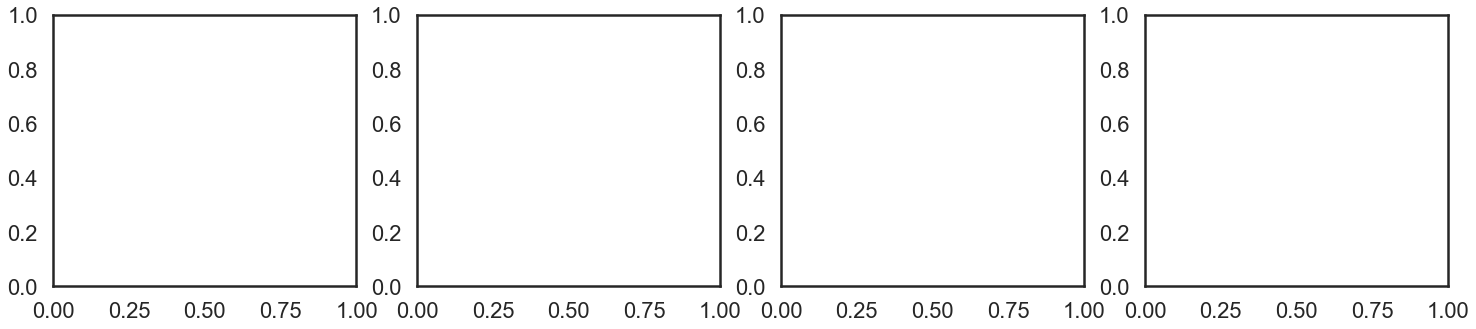

In [39]:
## Insert reg spectral clustering algorithm here and then compare cluster
## indices with cluster indicies from above to see the similarities
filename = "2_PCA.csv"
data2 = pandas.read_csv(filename)
goto = np.shape(data2)[0]

fig_PCA, axes_PCA = plt.subplots(1,4)
fig_PCA.set_figheight(5)
fig_PCA.set_figwidth(25)

In [40]:
# compute A (step 1)
# experiment with sigsq in question 8
sigsq = .9
Aisq = np.power(data2.iloc[:,0], 2) + np.power(data2.iloc[:,1], 2)
# type(Aisq)
Dotprod = data2.dot(data2.T)

distmat = - repmat(Aisq, goto, 1) - repmat(Aisq.values.reshape(-1,1), 1, goto)  + 2*Dotprod
Afast = np.exp(distmat / (2*sigsq))
A = Afast - np.diag(np.diag(Afast))

ax = axes_PCA[0]
ax.set_title("Affinity Matrix")
im = ax.imshow(A, extent=[0, 1, 0, 1])
fig_PCA.colorbar(im, ax=ax)

In [41]:
# step 2
D = np.diag(np.sum(A.T, axis=0))
L = np.linalg.inv(np.sqrt(D)).dot(A).dot(np.linalg.inv(np.sqrt(D)))
vmax = np.amax(np.ndarray.max(L, axis=0))
vmin = np.amin(np.ndarray.min(L, axis=0))

ax = axes_PCA[1]
ax.set_title("Normalized Graph Laplacian")
im = ax.imshow(L, extent=[0, 1, 0, 1])
im.set_clim(vmin, vmax/100) # Dividing vmax by a large enough constant to get good color on the graph
fig_PCA.colorbar(im, ax=ax)

In [42]:
# step 3 
di, X = np.linalg.eig(L)
Xsort, Dsort = eigsort(X,di)
Xuse = Xsort[:, :2]

ax = axes_PCA[2]
ax.set_title("Top k Eigenvectors")
im = ax.imshow(Xuse, extent=[0, 1, 0, 1])
fig_PCA.colorbar(im, ax=ax)

In [43]:
# normalize X to get Y (step 4)
Xsq = np.multiply(Xuse, Xuse)
divmat = repmat(np.sqrt(np.sum(Xsq.T, axis=0)).reshape(-1,1), 1, 2)
Y = np.divide(Xuse, divmat)

ax = axes_PCA[3]
ax.set_title("Normalized Eigenvectors")
im = ax.imshow(Y, extent=[0, 1, 0, 1])
fig_PCA.colorbar(im, ax=ax)

In [8]:
fig_PCA.tight_layout()
fig_PCA.savefig("PCA_Spectral_Clustering.png")

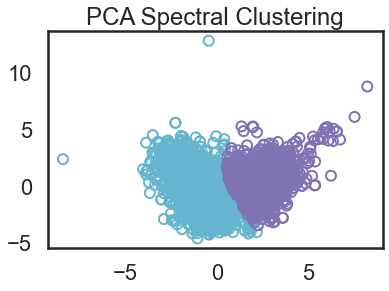

In [44]:
# step 5/6
kmeans = KMeans(n_clusters=2).fit(Y)
kk_PCA = kmeans.labels_
c1 = np.argwhere(kk_PCA == 0).flatten()
c2 = np.argwhere(kk_PCA == 1).flatten()

plt.scatter(data2.iloc[c1].iloc[:,0], data2.iloc[c1].iloc[:,1], edgecolor='c', marker='o', facecolor='none', s=100)
plt.scatter(data2.iloc[c2].iloc[:,0], data2.iloc[c2].iloc[:,1], edgecolor='m', marker='o', facecolor='none', s=100)
plt.title('PCA Spectral Clustering')
plt.savefig("Kmeans_withPCA.png")

In [34]:
kk_nonPCA

array([1, 1, 1, ..., 0, 0, 1], dtype=int32)

In [45]:
kk

array([1, 1, 1, ..., 0, 0, 1], dtype=int32)

In [49]:
vec_compare = pandas.DataFrame(data={'woPCA': kk_nonPCA, 'wPCA': kk})
vec_compare.to_csv("vec_compare.csv")